# Attribution par facteur
D’où vient le rendement d'un fonds ?  
On explique les rendements excédentaires du fonds par les facteurs académiques :
* βi​ = sensibilité du fonds au facteur i
* α = performance non expliquée par ces facteurs

Données utilisées :
* NAV mensuelles ou hebdomadaires du fonds/ETF
* Facteurs Fama-French

Description du fichier de facteurs :

`MonthId`
* Type : entier (YYYYMM)
* Description : Identifiant du mois de l’observation - Exemple : 196307 = juillet 1963.
* Usage : Sert d’index temporel pour aligner facteurs, rendements du fonds et séries macro.

`Mkt-RF`
* Nom complet : Excess Market Return
* Type : float (%)
* Définition : Rendement du portefeuille de marché (value-weighted US equities) moins le taux sans risque (RF).
* Interprétation : Facteur de risque de marché (le premier facteur CAPM).
* Usage en attribution : Charge en bêta du fonds → exposition directionnelle au marché.

`SMB`
* Nom complet : Small Minus Big
* Type : float (%)
* Définition : Surperformance moyenne des portefeuilles "petites capitalisations" sur les grandes capitalisations.
* Construction 2×3 : Moyenne de 6 portefeuilles classés par taille × 3 niveaux de “book-to-market”, “operating profitability”, “investment”.
* Interprétation : Prime de taille.
* Usage en attribution : Exposition aux small caps (portefeuilles spécialisés, value/small tilt, etc.).

`HML`
* Nom complet : High Minus Low (Value Factor)
* Type : float (%)
* Définition : Surperformance moyenne des actions Value (haut book-to-market) vs Growth (bas book-to-market).
* Construction 2×3 : Portefeuilles triés taille × book-to-market.
* Interprétation : Prime Value.
* Usage : Explique les biais Value/Growth.

`RMW`
* Nom complet : Robust Minus Weak (Profitability Factor)
* Type : float (%)
* Définition : Surperformance des entreprises à profitabilité robuste vs faible.
* Construction 2×3 : Portefeuilles triés taille × operating profitability.
* Interprétation : Prime de profitabilité (Cooper, Gulen, Schill ; Fama-French 2015).
* Usage : Détecte un tilt vers les entreprises “quality/profitable”.

`CMA`
* Nom complet : Conservative Minus Aggressive (Investment Factor)
* Type : float (%)
* Définition : Surperformance des entreprises faiblement investisseuses vs fortement investisseuses.
* Interprétation : Facteur d’investissement — entreprises prudentes vs expansion agressive.
* Usage : Explique les biais vers les entreprises conservatrices / capital-light.

`RF`
* Nom complet : Risk-Free Rate
* Type : float (%)
* Définition : Taux sans risque à un mois (T-bill 1-month).
* Usage : Permet de calculer les rendements excédentaires du fonds et sert au facteur Mkt-RF.

`UMD`
* Nom complet : Up Minus Down (Momentum Factor)
* Type : float (%)
* Définition : Surperformance moyenne des portefeuilles d’actions “gagnantes” (rendements passés élevés) sur les portefeuilles “perdantes” (rendements passés faibles), où les gagnants et perdants sont définis sur le rendement cumulé des 12 derniers mois hors le plus récent (mois t-12 à t-2), en pondération value-weighted.
* Interprétation : Prime de Momentum – les actions qui ont récemment bien performé tendent à continuer de surperformer, et inversement pour les perdantes.
* Usage : Mesure un tilt Momentum (β_UMD > 0) ou anti-Momentum (β_UMD < 0) d’un fonds ; permet de reclasser une partie de l’« alpha » comme exposition systématique à la stratégie gagnants–perdants.

In [21]:
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson, jarque_bera

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Charger FF5
df_factors = pd.read_csv('FF5+Momentum.csv')

In [3]:
# Encodage date
df_factors['month_enddate'] = pd.to_datetime(df_factors['MonthId'], format='%Y%m') + pd.offsets.MonthEnd(0)
df_factors = df_factors.set_index('month_enddate').drop(columns=['MonthId'])

In [4]:
# Chargement des rendements de l'univers des ETF
df_returns_raw = pd.read_csv("iShares_ETF_monthly_returns.csv", parse_dates=["Date"])
df_returns_raw

,Date,IVV,IWB,IWF,IJH,IJR,IWM,IWD,IVW,IVE,...,MTUM,VLUE,SIZE,QUAL,DGRO,LRGF,SMLF,SMMV,SMMD,DIVB
0,2000-05-31,-2.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-06-30,2.47,2.51,7.60,1.48,5.89,8.69,-4.68,8.05,-3.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-07-31,-1.57,-1.70,-4.41,1.51,-2.48,-3.25,1.39,-4.48,1.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-08-31,6.19,7.44,9.18,11.13,8.82,7.59,5.54,5.77,6.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-09-30,-5.27,-4.68,-9.53,-0.69,-2.74,-3.24,0.86,-9.76,-0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,2025-06-30,5.08,5.05,6.36,3.58,4.03,5.40,3.40,6.32,3.67,...,4.02,6.55,3.59,3.39,3.48,4.98,4.64,0.45,4.64,4.30
302,2025-07-31,2.24,2.21,3.76,1.62,0.92,1.71,0.56,3.41,0.87,...,0.33,-0.29,1.14,0.72,0.98,2.21,2.00,-1.26,1.91,-0.43
303,2025-08-31,2.03,2.10,1.10,3.39,7.05,7.13,3.18,0.81,3.43,...,1.02,5.95,2.31,2.57,3.53,1.96,5.37,4.03,5.30,3.98
304,2025-09-30,3.65,3.46,5.29,0.45,0.99,3.12,1.48,5.28,1.75,...,5.51,5.12,1.11,3.22,2.35,3.71,2.11,0.36,1.65,0.91


In [5]:
# unpivot / melt en format long
df_returns = (
    df_returns_raw
    .melt(id_vars="Date", var_name='ticker', value_name='monthly_return')
    .dropna(subset=['monthly_return'])  # retire les lignes sans données
    .sort_values(['Date', "ticker"])
    .reset_index(drop=True)
)

# affichage / sauvegarde
df_returns

,Date,ticker,monthly_return
0,2000-05-31,IVV,-2.12
1,2000-06-30,IJH,1.48
2,2000-06-30,IJR,5.89
3,2000-06-30,IVE,-3.93
4,2000-06-30,IVV,2.47
...,...,...,...
12101,2025-10-31,SMLF,-0.03
12102,2025-10-31,SMMD,0.64
12103,2025-10-31,SMMV,-2.58
12104,2025-10-31,USMV,-2.02


In [6]:
# Chargement des caractéristiques des ETF
df_universe = pd.read_csv("iShares_Universe.csv")
df_universe

,Ticker,Name,Inception Date,Category,Factor_bucket,Notes
0,IVV,iShares Core S&P 500 ETF,2000-05-15,Large Cap,Core,"S&P 500 low-cost, core US large caps."
1,IWB,iShares Russell 1000 ETF,2000-05-15,Large/Mid Cap,Core,Russell 1000 broad US large+mid core exposure.
2,IWF,iShares Russell 1000 Growth ETF,2000-05-22,Large/Mid Cap,Value-Growth,Russell 1000 growth sleeve (large+mid growth).
3,IJH,iShares Core S&P Mid-Cap ETF,2000-05-22,Mid Cap,Size,Core S&P Mid-Cap exposure (US mid caps).
4,IJR,iShares Core S&P Small-Cap ETF,2000-05-22,Small Cap,Size,Core S&P Small-Cap exposure (US small caps).
5,IWM,iShares Russell 2000 ETF,2000-05-22,Small Cap,Size,Russell 2000 benchmark for US small caps.
6,IWD,iShares Russell 1000 Value ETF,2000-05-22,Large/Mid Cap,Value-Growth,Russell 1000 value sleeve (large+mid value).
7,IVW,iShares S&P 500 Growth ETF,2000-05-22,Large Cap,Value-Growth,S&P 500 growth sleeve (large-cap growth).
8,IVE,iShares S&P 500 Value ETF,2000-05-22,Large Cap,Value-Growth,S&P 500 value sleeve (large-cap value).
9,IWV,iShares Russell 3000 ETF,2000-05-22,All Cap,Core,Russell 3000 broad US equity market (total mar...


In [7]:
series_by_ticker = {}

tickers = (
    df_universe["Ticker"]
    .dropna()
    .astype(str)
    .str.strip()
    .unique()
)

tickers

array(['IVV', 'IWB', 'IWF', 'IJH', 'IJR', 'IWM', 'IWD', 'IVW', 'IVE',
       'IWV', 'IUSG', 'IUSV', 'IWO', 'IWN', 'IJK', 'IJJ', 'IJS', 'IJT',
       'OEF', 'IWR', 'IWP', 'IWS', 'DVY', 'ITOT', 'IMCG', 'ILCG', 'IMCB',
       'ILCB', 'ILCV', 'IMCV', 'ISCG', 'ISCV', 'ISCB', 'IWC', 'IWY',
       'IWX', 'IWL', 'EUSA', 'HDV', 'USMV', 'MTUM', 'VLUE', 'SIZE',
       'QUAL', 'DGRO', 'LRGF', 'SMLF', 'SMMV', 'SMMD', 'DIVB'],
      dtype=object)

In [8]:
# Boucle sur les tickers pour réaliser les régressions Factor Attribution
rows = []
for t in tickers:
    df_sub = (
        df_returns.loc[df_returns["ticker"].astype(str).str.strip() == t, ["Date", "monthly_return"]]
        .dropna()
        .copy()
    )

    if df_sub.empty:
        continue
    
    
    df_sub["Date"] = pd.to_datetime(df_sub["Date"])

    df_fund = df_sub.sort_values("Date").set_index("Date")
    df_fund.name = str(t).strip()
    series_by_ticker[df_fund.name] = df_fund

    # Ajout des facteurs
    df_fund = df_fund.join(df_factors, how='inner')
    if df_fund.empty:
        continue

    # Calcul du rendement excédentaire du fonds
    df_fund['fund_excess'] = df_fund['monthly_return'] - df_fund['RF']

    # Statsmodels OLS
    X = df_fund[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA','UMD']]
    X = sm.add_constant(X)
    y = df_fund['fund_excess']

    # garde-fou: pas de régression si trop peu d'observations
    if len(df_fund) < (X.shape[1] + 5):
        continue

    # cov_type='HAC' compute heteroskedasticity-and-autocorrelation-consistent covariances (Newey–West style). 
    # cov_kwds={'maxlags':6} supplies options to that estimator.
    # maxlags is the lag truncation used to account for serial correlation up to lag 6 (and typically uses a Bartlett kernel by default).
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})

    params = model.params.to_dict()
    row = {
        "ticker": str(t).strip(),
        "n_obs": int(model.nobs),
        "rsquared": float(model.rsquared),
        "rsquared_adj": float(model.rsquared_adj),
        "model_summary": model.summary().as_text(),
        **params,  # colonnes: const, Mkt-RF, SMB, ...
    }
    rows.append(row)

df_models = pd.DataFrame(rows)

base_cols = ["ticker", "n_obs", "rsquared", "rsquared_adj", "const", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD", "model_summary"]
df_models = df_models.reindex(columns=[c for c in base_cols if c in df_models.columns] + [c for c in df_models.columns if c not in base_cols])
df_models.to_csv("iShares_FF5_factor_attribution.csv", index=False)

In [9]:
series_by_ticker["IVV"].head()

,monthly_return
Date,
2000-05-31,-2.12
2000-06-30,2.47
2000-07-31,-1.57
2000-08-31,6.19
2000-09-30,-5.27


In [15]:
# Paramètres
WINDOW = 60 # fenêtre de calcul des rolling beta (en mois)
FACTORS = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD"]
HAC_MAXLAGS = 6

rows = []
series_by_ticker = {}  # pour conserver les séries

for t in tickers:
    ticker = str(t).strip()

    df_sub = (
        df_returns.loc[df_returns["ticker"].astype(str).str.strip() == ticker, ["Date", "monthly_return"]]
        .dropna()
        .copy()
    )
    if df_sub.empty:
        continue

    df_sub["Date"] = pd.to_datetime(df_sub["Date"])
    df_fund = df_sub.sort_values("Date").set_index("Date")
    df_fund.name = ticker
    series_by_ticker[ticker] = df_fund

    # Join facteurs (df_factors est indexé par Date en datetime)
    df_fund = df_fund.join(df_factors, how="inner").sort_index()
    if df_fund.empty:
        continue

    # Rendement excédentaire
    df_fund["fund_excess"] = df_fund["monthly_return"] - df_fund["RF"]

    # On ne garde que les colonnes utiles (et on drop les NaN au fil des fenêtres)
    needed = ["fund_excess"] + FACTORS
    df_fund = df_fund.dropna(subset=needed)

    if len(df_fund) < WINDOW:
        continue

    # Rolling regressions : une régression par mois, sur les 60 derniers points
    for end_loc in range(WINDOW - 1, len(df_fund)):
        df_win = df_fund.iloc[end_loc - WINDOW + 1 : end_loc + 1]

        # On vérifie si la fenêtre est complète
        if len(df_win) < WINDOW:
            continue

        X = sm.add_constant(df_win[FACTORS], has_constant="add")
        y = df_win["fund_excess"]

        # garde-fou: pas de régression si trop peu d'observations vs nb de variables
        if len(df_win) < (X.shape[1] + 5):
            continue

        try:
            model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": HAC_MAXLAGS})
        except Exception:
            continue

        row = {
            "ticker": ticker,
            "window_start": df_win.index.min(),
            "window_end": df_win.index.max(),
            "n_obs": int(model.nobs),
            "rsquared": float(model.rsquared),
            "rsquared_adj": float(model.rsquared_adj),
        }

        # Coefficients
        params = model.params.to_dict()
        row.update(params)

        # Détails (optionnel mais utile)
        bse = model.bse.to_dict()
        pvals = model.pvalues.to_dict()
        for k, v in bse.items():
            row[f"{k}_se"] = float(v)
        for k, v in pvals.items():
            row[f"{k}_pval"] = float(v)

        rows.append(row)
        
        # Calcul du résiduel
        # model.fittedvalues = les valeurs ajustées ŷ in-sample sur cette même fenêtre
        # (y - model.fittedvalues) = la série des résiduels sur la fenêtre
        # .iloc[-1] = le résiduel du dernier mois de la fenêtre (le mois window_end)
        # On ne cherche à conserver qu'un résiduel par fenêtre (le dernier), pas la série complète.
        # On aurait pu calculer : df_rolling.loc[len(df_rolling) - 1, "residual"] = (y - model.fittedvalues).iloc[-1]
        # Mais Statsmodels expose déjà model.resid qui est exactement y - fittedvalues.
        row["residual"] = float(model.resid.iloc[-1])  # équivalent à (y - model.fittedvalues).iloc[-1]

df_rolling = pd.DataFrame(rows)

# Ordonner les colonnes
base_cols = [
    "ticker", "window_start", "window_end", "n_obs", "rsquared", "rsquared_adj",
    "const", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD", "residual"
]
detail_cols = []
for k in ["const"] + FACTORS:
    detail_cols += [f"{k}_se", f"{k}_pval"]

ordered = [c for c in base_cols if c in df_rolling.columns] + \
          [c for c in detail_cols if c in df_rolling.columns] + \
          [c for c in df_rolling.columns if c not in set(base_cols + detail_cols)]

df_rolling = df_rolling.reindex(columns=ordered)

# Format dates (optionnel)
if "window_start" in df_rolling.columns:
    df_rolling["window_start"] = pd.to_datetime(df_rolling["window_start"]).dt.date
if "window_end" in df_rolling.columns:
    df_rolling["window_end"] = pd.to_datetime(df_rolling["window_end"]).dt.date

df_rolling.to_csv("iShares_FF5_rolling60_factor_betas_by_month.csv", index=False)

In [16]:
# Paramètres
WINDOW = 36 # fenêtre de calcul des rolling beta (en mois)
FACTORS = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD"]
HAC_MAXLAGS = 6

rows = []
series_by_ticker = {}  # pour conserver les séries

for t in tickers:
    ticker = str(t).strip()

    df_sub = (
        df_returns.loc[df_returns["ticker"].astype(str).str.strip() == ticker, ["Date", "monthly_return"]]
        .dropna()
        .copy()
    )
    if df_sub.empty:
        continue

    df_sub["Date"] = pd.to_datetime(df_sub["Date"])
    df_fund = df_sub.sort_values("Date").set_index("Date")
    df_fund.name = ticker
    series_by_ticker[ticker] = df_fund

    # Join facteurs (df_factors est indexé par Date en datetime)
    df_fund = df_fund.join(df_factors, how="inner").sort_index()
    if df_fund.empty:
        continue

    # Rendement excédentaire
    df_fund["fund_excess"] = df_fund["monthly_return"] - df_fund["RF"]

    # On ne garde que les colonnes utiles (et on drop les NaN au fil des fenêtres)
    needed = ["fund_excess"] + FACTORS
    df_fund = df_fund.dropna(subset=needed)

    if len(df_fund) < WINDOW:
        continue

    # Rolling regressions : une régression par mois, sur les 36 derniers points
    for end_loc in range(WINDOW - 1, len(df_fund)):
        df_win = df_fund.iloc[end_loc - WINDOW + 1 : end_loc + 1]

        # On vérifie si la fenêtre est complète
        if len(df_win) < WINDOW:
            continue

        X = sm.add_constant(df_win[FACTORS], has_constant="add")
        y = df_win["fund_excess"]

        # garde-fou: pas de régression si trop peu d'observations vs nb de variables
        if len(df_win) < (X.shape[1] + 5):
            continue

        try:
            model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": HAC_MAXLAGS})
        except Exception:
            continue

        row = {
            "ticker": ticker,
            "window_start": df_win.index.min(),
            "window_end": df_win.index.max(),
            "n_obs": int(model.nobs),
            "rsquared": float(model.rsquared),
            "rsquared_adj": float(model.rsquared_adj),
        }

        # Coefficients
        params = model.params.to_dict()
        row.update(params)

        # Détails (optionnel mais utile)
        bse = model.bse.to_dict()
        pvals = model.pvalues.to_dict()
        for k, v in bse.items():
            row[f"{k}_se"] = float(v)
        for k, v in pvals.items():
            row[f"{k}_pval"] = float(v)

        rows.append(row)

        # Calcul du résiduel
        # model.fittedvalues = les valeurs ajustées ŷ in-sample sur cette même fenêtre
        # (y - model.fittedvalues) = la série des résiduels sur la fenêtre
        # .iloc[-1] = le résiduel du dernier mois de la fenêtre (le mois window_end)
        # On ne cherche à conserver qu'un résiduel par fenêtre (le dernier), pas la série complète.
        # On aurait pu calculer : df_rolling.loc[len(df_rolling) - 1, "residual"] = (y - model.fittedvalues).iloc[-1]
        # Mais Statsmodels expose déjà model.resid qui est exactement y - fittedvalues.
        row["residual"] = float(model.resid.iloc[-1])  # équivalent à (y - model.fittedvalues).iloc[-1]

df_rolling = pd.DataFrame(rows)

# Ordonner les colonnes
base_cols = [
    "ticker", "window_start", "window_end", "n_obs", "rsquared", "rsquared_adj",
    "const", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD", "residual"
]
detail_cols = []
for k in ["const"] + FACTORS:
    detail_cols += [f"{k}_se", f"{k}_pval"]

ordered = [c for c in base_cols if c in df_rolling.columns] + \
          [c for c in detail_cols if c in df_rolling.columns] + \
          [c for c in df_rolling.columns if c not in set(base_cols + detail_cols)]

df_rolling = df_rolling.reindex(columns=ordered)

# Format dates (optionnel)
if "window_start" in df_rolling.columns:
    df_rolling["window_start"] = pd.to_datetime(df_rolling["window_start"]).dt.date
if "window_end" in df_rolling.columns:
    df_rolling["window_end"] = pd.to_datetime(df_rolling["window_end"]).dt.date

df_rolling.to_csv("iShares_FF5_rolling36_factor_betas_by_month.csv", index=False)

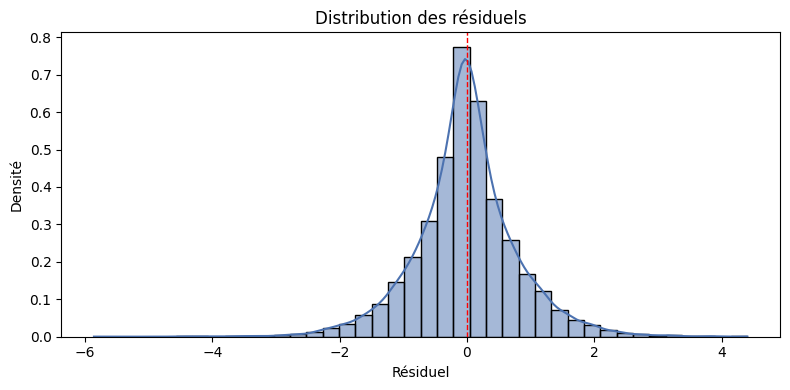

In [37]:
# On souhaite maintenant expliquer le résiduel du modèle de facteurs (FF5 + Momentum) en ajoutant des variables macroéconomiques.
# On veut comprendre dans quel contexte le fonds fait nettement mieux ou nettement pire que ce qu’on attendrait, compte tenu de son exposition aux facteurs et du régime macro.
# Le résiduel du modèle de facteurs est netté des expositions structurelles (Value, Size, Momentum…)
# Il mesure la sur-/sous-performance conditionnelle au style et se prête bien à la recherche de règles

# On commence par sélectionner les variables pertinentes de df_rolling avant d'ajouter des variables macroéconomiques.
df_train = df_rolling[['ticker', 'window_end', 'residual', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']].copy()

# TODO: représente la distribution des résiduels

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(df_train['residual'], bins=40, kde=True, stat='density', color='#4C72B0')
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.title('Distribution des résiduels')
plt.xlabel('Résiduel')
plt.ylabel('Densité')
plt.tight_layout()
plt.show()


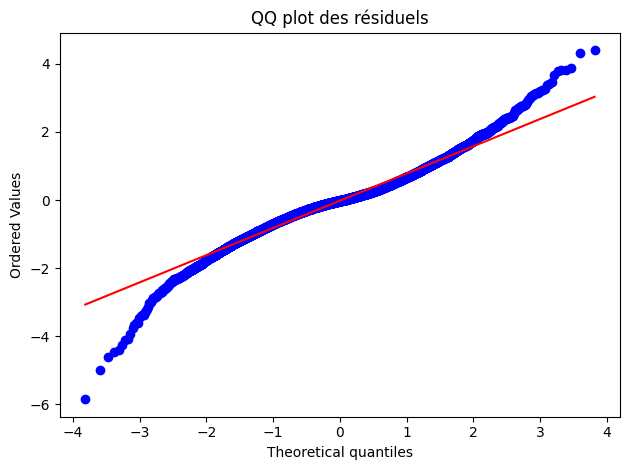

In [38]:
import scipy.stats as stats

stats.probplot(df_train['residual'], dist="norm", plot=plt)
plt.title('QQ plot des résiduels')
plt.tight_layout()
plt.show()


In [39]:
# À partir du résiduel du modèle de facteurs, on calcule une variable cible ordinale à 3 états
# Underperformance : sous-performance anormale < 1 sigma,
# Neutral : performance en ligne,
# Overperformance : surperformance anormale > 1 sigma.

sigma = df_train['residual'].std()

df_train = df_train.assign(
    target=pd.cut(
        df_train['residual'],
        bins=[-float('inf'), -sigma, sigma, float('inf')],
        labels=['Underperformance', 'Neutral', 'Overperformance'],
        ordered=True
    )
)


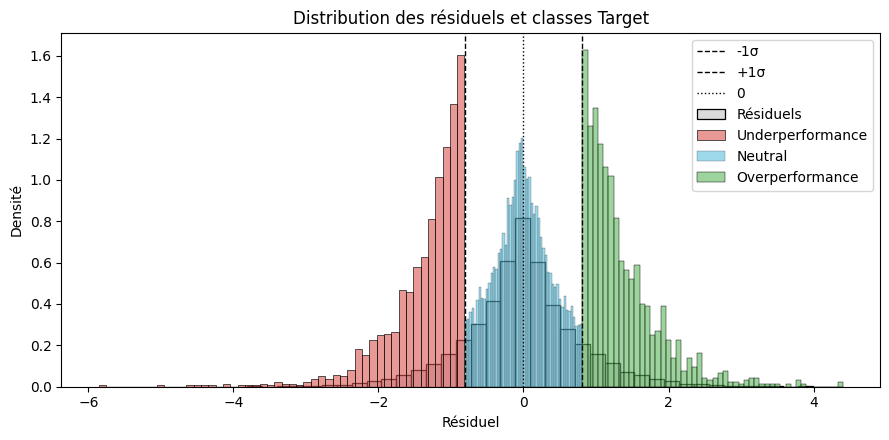

In [40]:
# Visualisation de la distribution des résiduels par classe Target
sigma = df_train['residual'].std()

# Palette par classe
palette = {
    'Underperformance': '#d9534f',  # rouge
    'Neutral': '#5bc0de',           # bleu clair
    'Overperformance': '#5cb85c'    # vert
}

plt.figure(figsize=(9, 4.5))

# Histogramme global
sns.histplot(df_train['residual'], bins=50, stat='density', color='#999999', alpha=0.35, label='Résiduels')

# Histogrammes par classe
for cls, color in palette.items():
    subset = df_train[df_train['target'] == cls]
    if len(subset):
        sns.histplot(subset['residual'], bins=50, stat='density', color=color, alpha=0.6, label=cls)

# Lignes de seuil ±1σ
plt.axvline(-sigma, color='black', linestyle='--', linewidth=1, label='-1σ')
plt.axvline(sigma, color='black', linestyle='--', linewidth=1, label='+1σ')
plt.axvline(0, color='black', linestyle=':', linewidth=1, label='0')

plt.title('Distribution des résiduels et classes Target')
plt.xlabel('Résiduel')
plt.ylabel('Densité')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Alternative : On change l'horizon temporel de la cible
# Comme les macros macroéconomiques FRED sont relativement lentes, on reconstruit une cible sur un horizon 3, 6 ou 12 mois :
# Exemple : y_3m = somme des résiduels sur les 3 derniers mois
# Cela réduit le bruit mensuel et met en cohérence la granularité avec les régimes macro.

df_train = df_train.sort_values(['ticker', 'window_end'])

horizon = 3  # 3, 6 ou 12

# Somme roulante des résiduels par ticker
df_train[f'residual_{horizon}m'] = (
    df_train
    .groupby('ticker')['residual']
    .transform(lambda s: s.rolling(window=horizon, min_periods=horizon).sum())
)

# Seuils (ici au global ; si tu préfères par ticker, calcule sigma dans une transform)
sigma = df_train[f'residual_{horizon}m'].std()

df_train = df_train.assign(
    target_v2=pd.cut(
        df_train[f'residual_{horizon}m'],
        bins=[-float('inf'), -sigma, sigma, float('inf')],
        labels=['Underperformance', 'Neutral', 'Overperformance'],
        ordered=True
    )
)

# Option : filtrer les lignes sans fenêtre complète
df_train = df_train.dropna(subset=[f'residual_{horizon}m', 'target_v2'])
# df_train.to_csv("df_train.csv", index=False)
df_train


,ticker,window_end,residual,Mkt-RF,SMB,HML,RMW,CMA,UMD,target,residual_3m,target_v2
9833,DGRO,2017-08-31,0.320358,0.969084,-0.127385,0.037286,0.094913,0.272130,0.058930,Neutral,0.071809,Neutral
9834,DGRO,2017-09-30,0.208237,0.973467,-0.120312,0.039493,0.092195,0.277382,0.062515,Neutral,-0.533721,Neutral
9835,DGRO,2017-10-31,-0.078235,0.970703,-0.138696,0.057358,0.089897,0.263235,0.061913,Neutral,0.450361,Neutral
9836,DGRO,2017-11-30,0.623797,0.978266,-0.133915,0.060372,0.122811,0.259756,0.062801,Neutral,0.753799,Neutral
9837,DGRO,2017-12-31,-0.679486,0.975461,-0.129660,0.068998,0.133818,0.220223,0.060264,Neutral,-0.133924,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
9601,VLUE,2025-05-31,-0.157759,0.989912,-0.010511,0.498028,0.034941,0.076110,-0.142997,Neutral,0.732146,Neutral
9602,VLUE,2025-06-30,1.627178,1.023979,-0.080027,0.508061,-0.060760,0.142669,-0.179014,Overperformance,1.386067,Neutral
9603,VLUE,2025-07-31,-1.489432,1.034124,-0.073330,0.510460,-0.041835,0.117027,-0.175715,Underperformance,-0.020013,Neutral
9604,VLUE,2025-08-31,1.236402,1.037251,-0.061478,0.518426,-0.021793,0.114205,-0.181894,Overperformance,1.374148,Neutral


In [ ]:
# On cherche des règles explicatives du type : 
# “Lorsque {courbe des taux inversée} & {VIX en régime High} & {fond = Growth large caps}, la probabilité d’alpha anormalement négatif sur 3 mois double.”